### INSTRUCTIONS

* In this assignment, you will build a DNN for Binary Classification. 

* We'll use the Breast Cancer Dataset. We aren't going to preproces data or split it into train/test since the focus here is purely on coding up the DNN. 

* You've been given some helper functions and a FullyConnectedLayer class. This is on the lines of what we worked through in the class exercises on 3/17, with small modifications to account for different activation functions. 

* First be sure to work through the in-class exercise set we went over on 3/17.

* Then read through the entire framework below once. Note the parts you need to code up (indexed 1 through 13 in the comments below).

* Coding tasks 1 through 3: update three helper functions (calc_gZ, calc_dgZ_dZ, init_W) as per the instructions below. I would recommend waiting to get through the lecture on 3/22 to attempt tasks 1 through 3. You can continue to use these helper functions in their current form until then.

* Coding tasks 4 through 13: code up the FullyConnectedNetwork class per the instructions below. You can start on tasks 4 through 13 immediately. 

* NOTE: YOU WILL ONLY EDIT TWO CELLS FOR THIS ASSIGNMENT AS PER THE INSTRUCTIONS IN THOSE CELLS.

In [1]:
##### DO NOT EDIT THIS CELL!!!
##### DO NOT IMPORT ANY ADDITIONAL PACKAGES

import numpy as np
import scipy
import sklearn
import sklearn.datasets
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# THIS IS CELL 1 (of 2) YOU WILL EDIT PER THE ISNTRUCTIONS BELOW
# DO NOT CHANGE THE ARGUMENTS TO ANY OF THE FUNCTIONS

### Helper Functions ###

# Activation Function g
# Activation A = g(Z)
def calc_gZ(Z, g='logistic'):
    gZ = np.zeros((Z.shape[0], Z.shape[1]))
    # Check if g is 'logistic'
    if g == 'logistic':
        gZ = scipy.special.expit(Z) 
    # Else if g is 'relu':
    elif g == 'relu':
        # Set Appropriate gZ for relu activation
        gZ = np.maximum(0,Z)
    return gZ

# Derivative dg(Z)/dZ
def calc_dgZ_dZ(gZ, Z, g='logistic'):
    dgZ_dZ = np.zeros((Z.shape[0], Z.shape[1]))
    # Check if g is 'logistic'
    if g == 'logistic':
        dgZ_dZ = gZ*(1-gZ)
    # Else if g is 'relu'
    elif g == 'relu':
        # Set Appropriate dgZ_dZ for relu activation
        dgZ_dZ = (Z>0).astype(int)
    return dgZ_dZ

# Cost J
# Note: Asumming Binary Classification (logloss)
def calc_J(AL, Y):
    m = Y.shape[0] 
    # Average Log-Loss
    eps=1e-8
    clippedAL = np.maximum(eps, np.minimum(1-eps, AL))
    J = np.squeeze((-1./m) * (np.dot(Y.T,np.log(clippedAL)) + np.dot(1-Y.T, np.log(1-clippedAL))))    
    return J

'''
For the Output Layer:
For Certain Combinations of Activation+Loss (Logistic+LogLoss, Linear+MSE, Softmax+Crossentropy),
It's Typically More Efficient to Directly Compute and use dJ/dZ=AL-Y
Rather Than Computing dJ/dZ = dJ/dA * dA/dZ. 
NOTE: Asumming Binary Classification (Logistic+LogLoss)
'''

def calc_dJ_dZ(AL, Y):
    # Logistic Activation and Average Log-Loss 
    dJ_dZ = AL-Y
    return dJ_dZ

# Intialize Weights as per Activation Function
def init_W(nprev, n, g='logistic'):
    W = np.zeros((nprev, n))
    #If g is 'logistic' or 'tanh':
    if g == 'logistic':
        # Set W to Xavier Initialization
        W = np.random.randn(nprev,n)*np.sqrt(1/nprev)
    # Else if g is 'relu':
    elif g == 'relu':
        # Set W to Kaiming Initialization
        W = np.random.randn(nprev,n)*np.sqrt(2/nprev)
    # Otherwise, set W to np.random.randn(nprev, n)
    else:
        W = np.random.randn(nprev, n)
    return W

In [3]:
##### DO NOT EDIT THIS CELL!!!

### fully-connected layer class ###

class FullyConnectedLayer:
    
    # activation function g can be 'logistic' or 'relu' - defaults to 'logistic'
    def __init__(self, nprev, n, g='logistic'):
        
        # number of nodes in this layer
        self.n = n                   
        
        # number of nodes in previous layer
        self.nprev = nprev    
        
        # activation function for this layer
        self.g = g
        
        # initialize weights for this layer
        self.W = init_W(self.nprev, self.n, self.g) 
        
        # initialize bias for this layer
        self.b = np.zeros((1, self.n))       
        
        # these will get set in the forward method
        self.Aprev = None
        self.Z = None
        self.A = None
        
        # these will get set in the backward method
        self.dJ_dW = None
        self.dJ_db = None
    
    
    # forward pass for layer
    def forward(self, Aprev):
        
        self.Aprev = Aprev
        self.Z =  np.dot(self.Aprev, self.W) + self.b 
        self.A = calc_gZ(self.Z, self.g) # A = g(Z)
        
        return self.A

    
    # backward propagation for hidden layer
    # here we first compute dgZ_dZ, and then compute dJ_dZ = dJ_dA * dgZ_dZ
    def backward_hidden_layer(self, dJ_dA):
        
        m = self.A.shape[0] 
        
        dgZ_dZ = calc_dgZ_dZ(self.A, self.Z, self.g) # A = g(Z)
        dJ_dZ = np.multiply(dJ_dA, dgZ_dZ) # dJ/dZ = dJ/dA * dA/dZ = dJ/dA * dg(Z)/dZ
        self.dJ_dW = (1./m)*np.dot(self.Aprev.T, dJ_dZ)  # dJ/dW = dJ/dZ * dZ/dW  
        self.dJ_db = (1./m)*np.sum(dJ_dZ, axis=0, keepdims=True) # dJ/db = dJ/dZ * dZ/db 
        dJ_dAprev = np.dot(dJ_dZ, self.W.T) # dJ/dAprev = dJ/dZ * dZ/dAprev 
        
        return dJ_dAprev
    
    
    # backward propagation for output layer
    # here we directly compute dJ_dZ 
    def backward_output_layer(self, Y):
        
        m = self.A.shape[0] 
            
        dJ_dZ = calc_dJ_dZ(self.A, Y)
        self.dJ_dW = (1./m)*np.dot(self.Aprev.T, dJ_dZ)  # dJ/dW = dJ/dZ * dZ/dW  
        self.dJ_db = (1./m)*np.sum(dJ_dZ, axis=0, keepdims=True) # dJ/db = dJ/dZ * dZ/db 
        dJ_dAprev = np.dot(dJ_dZ, self.W.T) # dJ/dAprev = dJ/dZ * dZ/dAprev 
        
        return dJ_dAprev
    
    
    # gradient descent for layer
    def optimize(self, alpha):
        
        self.W = self.W - alpha*self.dJ_dW
        self.b = self.b - alpha*self.dJ_db
        

In [9]:
# THIS IS CELL 2 (of 2) YOU WILL EDIT PER THE ISNTRUCTIONS BELOW
# DO NOT CHANGE THE ARGUMENTS TO ANY OF THE METHODS IN THIS CLASS

### Fully Connected Network Class ###
### This Class Must Use the FullyConnectedLayer Class to Build the Network ###

class FullyConnectedNetwork:
    
    '''
    n0 is is the "number of nodes" (which is just number of features n) in input layer
    nH is the number of nodes in each hidden layer (for instance nH=(15,5) implies two hidden layers with 15 and 5 nodes) 
    nL is the number of nodes in the output layer
    hidden_g can be 'logistic' or 'relu', output_g can be 'logistic'
    '''
    
    def __init__(self, n0=0, nH=(), nL=0, hidden_g='logistic', output_g='logistic'):
        # Number of Nodes in Each Layer in Network 
        # (Input Layer Size, Followed by Hidden Layer Sizes, Followed by Output Layer Size)
        self.layer_sizes = [n0, *nH, nL]
        # Number of Layers in Network
        self.L = len(self.layer_sizes) - 1
        # Create the Network as a List of FullyConnectedLayer Objects
        self.layers = []
        # Input Layer is a Dummy Layer
        self.layers.append(None)
        # Create Hidden Layers 1 Through L-1 Based on nH and hidden_g
        for i in range(1, self.L):
            n = self.layer_sizes[i]
            nprev = self.layer_sizes[i-1]
            layer = FullyConnectedLayer(nprev, n, hidden_g)
            self.layers.append(layer)
        # Create Output Layer L Based on nL and output_g
        n = self.layer_sizes[self.L]
        nprev = self.layer_sizes[self.L-1]
        layer = FullyConnectedLayer(nprev, n, output_g)
        self.layers.append(layer)
        
    # Forward Pass for Network
    def forward_pass(self, Aprev):
        # Forward Pass Aprev From Layer 1 Through Layer L 
        # Note: A From Each Layer Will Become Aprev to the Next Layer
        for i in range(1, self.L+1):
            layer = self.layers[i]
            A = layer.forward(Aprev)
            Aprev = A
        # Return A (That Comes Out of Output Layer)
        return A
    
    # Backward Propagation for Network
    def backward_propagation(self, Y):
        # Use backward_output_layer to Back-Prop Through Output Layer L
        # Note: The dJ_dAprev From Each Layer Will Become the dJ_dA to the Previous Layer
        layer = self.layers[self.L]
        dJ_dAprev = layer.backward_output_layer(Y)
        dJ_dA = dJ_dAprev
        # Use backward_hidden_layer to Back-Prop Through Hidden Layers L-1,...,2,1
        # Note: The dJ_dAprev From Each Layer Will Become the dJ_dA to the Previous Layer
        for i in range (self.L-1,0, -1): 
            layer = self.layers[i]
            dJ_dAprev = layer.backward_hidden_layer(dJ_dA)
            dJ_dA = dJ_dAprev
            
    # Gradient Descent for Network
    def gradient_descent(self, alpha):
        # Use Optimize to Update Parameters for Layers 1,2,...,L
        for i in range(1, self.L+1):
            layer = self.layers[i]
            layer.optimize(alpha)

    # Fit the DNN Model to the Data
    def fit(self, X, Y, alpha=0.0075, nepochs=3000):
        costs = []
        for i in range(nepochs):
            # Forward Pass and Calculate Current Loss
            AL = self.forward_pass(X)
            J = calc_J(AL, Y)
            # Backward Propagation (Calculate Current Gradients)
            self.backward_propagation(Y)
            # Gradient Descent (Update Parameters)
            self.gradient_descent(alpha)
            # Append Caculated Loss to Costs
            costs.append(J)
        # Plot Costs Versus Iterations; Print Alpha and Final Cost in Plot Title
        plt.plot(np.squeeze(costs))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.title("alpha: " + str(alpha) + " cost: " + str(costs[-1]))
        plt.show()
        
    # Make Predictions for Given Input X (This Can Be Train or Test Data)
    # Note: Assuming Binary Classification
    def predict(self, X):
        # Given Input, Predict Output and Assign to Variable "Ypred"
        Ypred = np.round(self.forward_pass(X))
        # Return the Calculated "Ypred"
        return Ypred
    
    # Calculate Accuracy of Prediction by Comparing to Target Data
    # Note: Assuming Binary Classification
    def accuracy(self, Ypred, Y):
        # Given Predictions and Targets, Calculate Accuracy Score and Assign to Variable Score
        score = accuracy_score(Ypred, Y)
        # Return the Calculated Score
        return score

In [10]:
##### DO NOT EDIT THIS CELL!!!

# let's use the breast cancer dataset from sklearn
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
features = dataset.feature_names
X = dataset.data
Y = dataset.target
Y = Y.reshape(Y.shape[0], 1)
m = X.shape[0]
n = X.shape[1]

print (m, n)

569 30


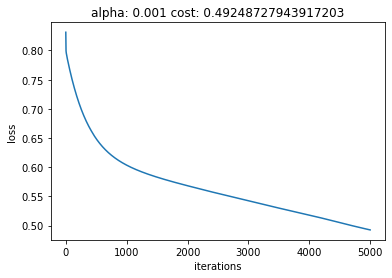

0.92


In [11]:
##### DO NOT EDIT THIS CELL!!!

# test number 1: 
# - nepochs=5000; alpha=0.001; nH=(15,); hidden_g='logistic'
# - this gives an accuracy of 0.92
# - with slow convergence (# of iternations to hit minimum cost) and final cost of 0.49

np.random.seed(42) 
nepochs = 5000 # number of epochs
alpha = 0.001 # learning rate

fcn = FullyConnectedNetwork(
    n0=n, nH=(15,), nL=1, 
    hidden_g='logistic', output_g='logistic')
fcn.fit (X, Y, alpha=alpha, nepochs=nepochs)
Ypred = fcn.predict(X)

score = fcn.accuracy(Ypred, Y)
print(round(score,2))

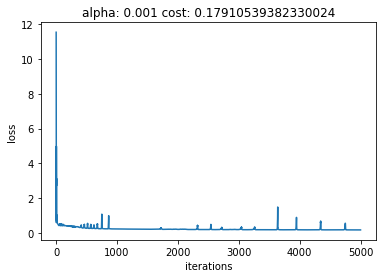

0.93


In [12]:
##### DO NOT EDIT THIS CELL!!!

# test number 2: 
# - nepochs=5000; alpha=0.001; nH=(15,); hidden_g='relu'
# - this gives an accuracy of 0.93
# - with very quick convergence (# of iternations to hit minimum cost) and final cost of 0.18

np.random.seed(42) 
nepochs = 5000 
alpha = 0.001 

fcn = FullyConnectedNetwork(
    n0=n, nH=(15,), nL=1, 
    hidden_g='relu', output_g='logistic')
fcn.fit (X, Y, alpha=alpha, nepochs=nepochs)
Ypred = fcn.predict(X)

score = fcn.accuracy(Ypred, Y)
print(round(score,2))

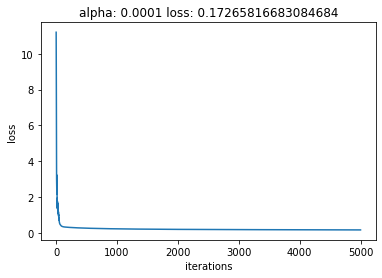

0.93


In [8]:
##### DO NOT EDIT THIS CELL!!!

# test number 3:
# - nepochs=5000; alpha=0.0001; nH=(15,5); hidden_g='relu'
# - this gives an accuracy of 0.93
# - with very quick convergence (# of iternations to hit minimum cost) and final cost of 0.17

np.random.seed(42) 
nepochs = 5000 
alpha = 0.0001 

fcn = FullyConnectedNetwork(
    n0=n, nH=(15,5), nL=1, 
    hidden_g='relu', output_g='logistic')
fcn.fit (X, Y, alpha=alpha, nepochs=nepochs)
Ypred = fcn.predict(X)

score = fcn.accuracy(Ypred, Y)
print(round(score,2))